# Some import

In [5]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import tqdm as tqdm

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, Concatenate

device = torch.device("mps")

# Load Data

In [6]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {8, 606}, str(val_lung_ids)
assert set(test_lung_ids) == {615, 731}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)

(136, 4, 6)

# Data Visualization

In [8]:
for i in range(len(train_dataset)):
    if train_dataset[i]['Lung_id'] == 6:
        tmp = train_dataset[i+2]
        break

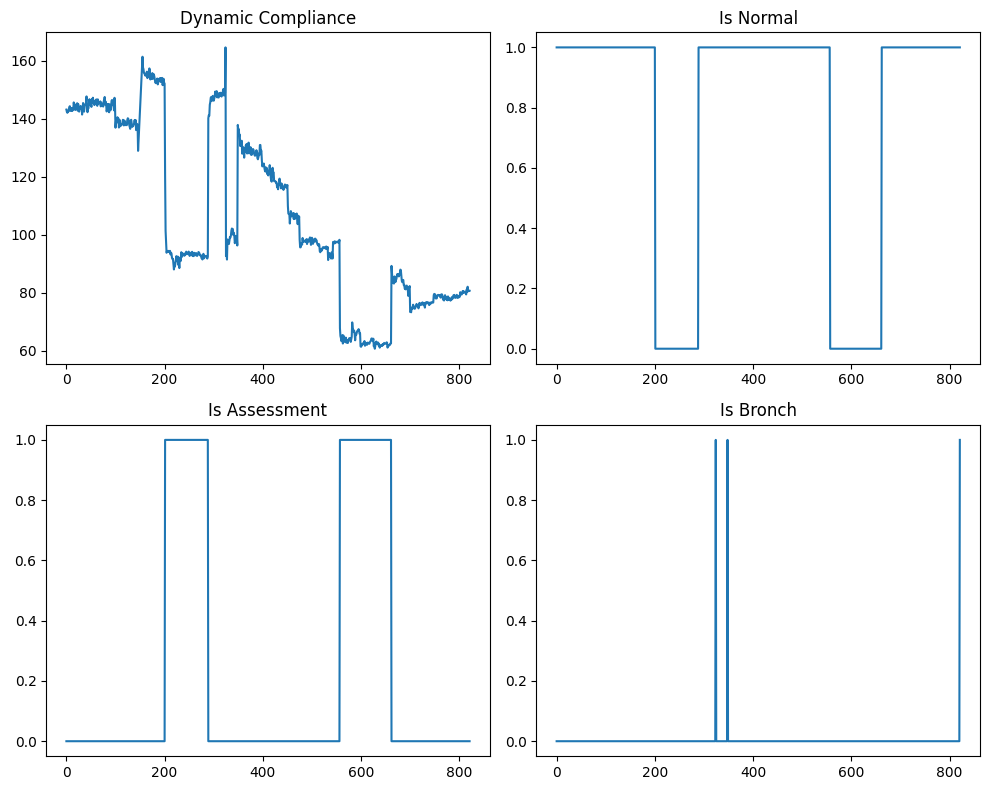

In [9]:
a = tmp['Dy_comp']
c = tmp['Is_normal']
b = tmp['Is_assessment']
d = tmp['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [10]:
def rindex(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [11]:
def center_pad_sequence(sequence, target_length): # centre pad with same value
        current_length = len(sequence)
        total_padding = target_length - current_length
        if total_padding <= 0:
            return sequence

        pad_before = total_padding // 2
        pad_after = total_padding - pad_before

        return np.pad(sequence, (pad_before, pad_after), mode='edge')
len(center_pad_sequence(train_dataset[0]['Is_bronch'][:1+1], 1470))

1470

# Set dataset

In [12]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []

for i in train_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start > last_assessment_start: # if bronch后面没有assessment
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))

print(f"length is {len(X_dc)}")    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

length is 118


In [13]:
X_dc = np.array(X_dc).reshape(-1, 1470)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470)
Y = torch.from_numpy(np.array(Y)).float()

## Don't do this if not PyTorch

In [14]:
# X_dc = torch.from_numpy(X_dc).float()
# X_is_normal = torch.from_numpy(X_is_normal).float()
# X_is_assess = torch.from_numpy(X_is_assess).float()
# X_is_bronch = torch.from_numpy(X_is_bronch).float()

X_combined = np.stack([X_dc, X_is_normal, X_is_assess, X_is_bronch], axis=1)  # Shape becomes [N, 4, 1470]
X_combined = torch.from_numpy(X_combined).float()


# Tensor Flow (Abandoned)

In [15]:
# input1 = Input(shape=(1470, 1))
# cnn1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
# cnn1 = MaxPooling1D(pool_size=2)(cnn1)
# cnn1 = Flatten()(cnn1)

# input2 = Input(shape=(1470, 1))
# cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(input2)
# cnn2 = MaxPooling1D(pool_size=2)(cnn2)
# cnn2 = Flatten()(cnn2)

# merge = Concatenate()([cnn1, cnn2])
# dense = Dense(50, activation='relu')(merge)
# output = Dense(1054, activation='linear')(dense)
# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit([X_dc, X_is_normal], Y, epochs=1000, verbose=0)

# PyTorch

In [16]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y):
        self.X_combined = X_combined
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx]
    
train_loader = DataLoader(EVLPDataset(X_combined, Y), batch_size=118, shuffle=True)

In [17]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv_seq = torch.nn.Sequential(
            self.conv1,
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )

        conv_output_size = self._calculate_conv_output_size()

        self.fc_seq = torch.nn.Sequential( 
            torch.nn.Linear(conv_output_size, 128),
            torch.nn.ReLU()
        )
        self.final_layer = nn.Linear(in_features=128, out_features=1054)

    def _calculate_conv_output_size(self):
        return 46976

    def forward(self, x):
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        x = self.final_layer(x)
        return x


In [32]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, y) in enumerate(train_loader):
            inputs, y = inputs.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)
        
        if epoch % 200 == 0:  
            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Loss: 8659.640625
Epoch 201, Loss: 147.77024841308594
Epoch 401, Loss: 135.0592803955078
Epoch 601, Loss: 97.18636322021484
Epoch 801, Loss: 86.37581634521484


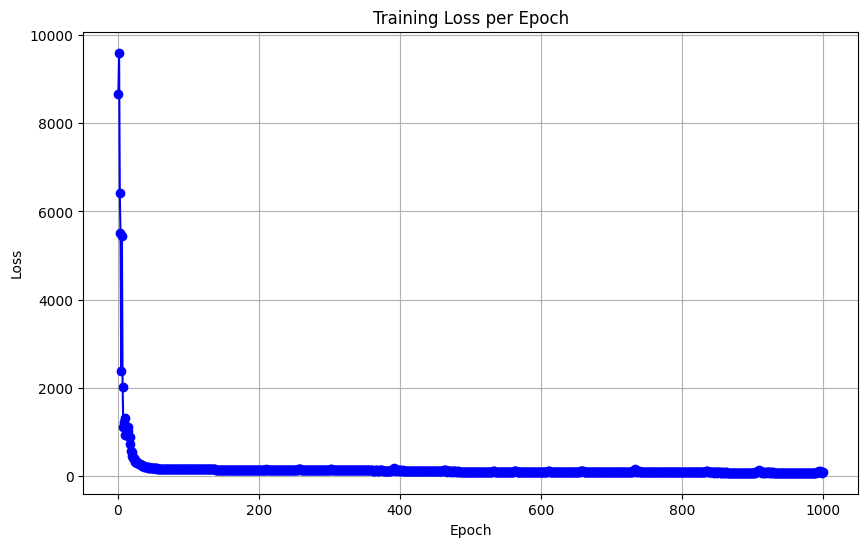

In [34]:
epochs = 1000
model = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train(model, train_loader, criterion, optimizer, epochs)